In [ ]:
%pip install skit tensorflow tensorflow_datasets tensorflow opencv-python matplotlib

In [ ]:
"""
Name: Babatunde Kalejaiye
Student ID: KAL20504783
CourseWork: 2
Course: Machine Learning
Date: 2024-11-22
"""

In [ ]:
import tensorflow as tf
import os

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class CelebADatasets(Dataset):
    """
    Custom dataset for CelebA.
    """
    def __init__(self, image_dir, attr_file, label_col="Smiling", transform=None):
        """
        Args:
            image_dir (str): Directory with all images.
            attr_file (str): Path to attributes file.
            label_col (str): Attribute to use as label.
            transform (callable, optional): Transformations to apply to images.
        """

        self.image_dir = image_dir
        self.transform = transform

        # Load attributes
        self.attributes = pd.read_csv(attr_file, sep=',', header=0)
        self.attributes.rename(columns={"Unnamed: 0": "image_id"}, inplace=True)

        # Select the label column
        if label_col not in self.attributes.columns:
            raise ValueError(f"Label column '{label_col}' not found in attributes.")
        self.data = self.attributes[["image_id", label_col]]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]["image_id"]
        # label = int((self.data.iloc[idx][1] + 1) / 2)  # Convert from {-1, 1} to {0, 1}
        label = int((self.data.iloc[idx]["Smiling"] + 1) / 2)

        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
import pandas as pd

# Path to the attributes file
attr_file = "img_align_celeba/list_attr_celeba.txt"

# Load the attributes
attributes = pd.read_csv(attr_file, sep=',', header=0)

# Print the first few rows and column names
print(attributes.head())
print("Columns in attributes:", attributes.columns)
print("Columns in attributes:", attributes.columns.tolist())
print("Is 'Smiling' in columns?", "Smiling" in attributes.columns)

In [ ]:
from prettytable import PrettyTable

# Create a table with column names
table = PrettyTable()
table.field_names = attributes.columns.tolist()

# Add the first few rows
for i in range(5):
    table.add_row(attributes.iloc[i].tolist())

print(table)

In [7]:
import os
import torch
from matplotlib import transforms
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader


# Paths
dataset_root = "img_align_celeba"
image_dir = "img_align_celeba"
attr_file = os.path.join(image_dir, "list_attr_celeba.txt")

# Transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Flip 50% of the time
    transforms.RandomRotation(15),          # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load full dataset
full_dataset = CelebADatasets(image_dir, attr_file, label_col="Smiling", transform=transform)

# Split into train/test
train_indices, test_indices = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        # self.fc2 = nn.Linear(64, 1)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
from torchvision.models import resnet18, ResNet18_Weights

# Load ResNet18 with the correct weights
weights = ResNet18_Weights.IMAGENET1K_V1  # Use the most relevant pre-trained weights
model = resnet18(weights=weights)

# Modify the final fully connected layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 1)

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False
model.fc.requires_grad = True

In [11]:
import torch.nn as nn
from torch.optim import Adam

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.0001)


# Training loop
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()  # Match labels' shape
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

# Test loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images).squeeze()
        predicted = torch.sigmoid(outputs) > 0.5
        correct += (predicted.int() == labels.int()).sum().item()
        total += labels.size(0)

print(f"Accuracy: {100 * correct / total}%")


Epoch 1, Loss: 0.3037243234800857
Epoch 2, Loss: 0.22101896452622788
Epoch 3, Loss: 0.20630860835505027
Epoch 4, Loss: 0.1993416706855829
Epoch 5, Loss: 0.1925998656912123
Accuracy: 91.87808489634749%


In [12]:
from prettytable import PrettyTable
import pandas as pd
import torch

# Assuming `attributes` contains the image information
# Assuming `test_indices` is a list of indices corresponding to the test set

# Create a table with column names
result_table = PrettyTable()
result_table.field_names = ["Image ID", "True Label", "Predicted Label", "Confidence"]

# Ground truth and predictions
y_true = []  # Ground truth labels
y_pred = []  # Model predictions
logits = []  # Raw logits from the model

# Generate predictions
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        predicted = (torch.sigmoid(outputs) > 0.5).int()

        # Append data
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        logits.extend(outputs.cpu().numpy())

# Populate the table
for idx, (true_label, pred_label, logit) in enumerate(zip(y_true, y_pred, logits)):
    # Get the image ID from the attributes file
    image_id = attributes.iloc[test_indices[idx]]["image_id"]

    # Convert the logit to a confidence score (between 0 and 1)
    confidence = torch.sigmoid(torch.tensor(logit)).item()

    # Add a row to the table
    result_table.add_row([
        image_id,
        "Smiling" if true_label == 1 else "Not Smiling",
        "Smiling" if pred_label == 1 else "Not Smiling",
        f"{confidence:.2f}"  # Format confidence to 2 decimal places
    ])

# Display the table in the console
print(result_table)


# from sklearn.metrics import classification_report

# y_true = []  # Ground truth labels
# y_pred = []  # Model predictions

# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images).squeeze()
#         predicted = (torch.sigmoid(outputs) > 0.5).int()
#         y_true.extend(labels.cpu().numpy())
#         y_pred.extend(predicted.cpu().numpy())

# print(classification_report(y_true, y_pred, target_names=["Not Smiling", "Smiling"]))

+------------+-------------+-----------------+------------+
|  Image ID  |  True Label | Predicted Label | Confidence |
+------------+-------------+-----------------+------------+
| 093242.jpg | Not Smiling |   Not Smiling   |    0.12    |
| 121414.jpg | Not Smiling |   Not Smiling   |    0.02    |
| 010625.jpg | Not Smiling |   Not Smiling   |    0.09    |
| 082524.jpg |   Smiling   |     Smiling     |    0.98    |
| 073193.jpg |   Smiling   |     Smiling     |    1.00    |
| 176200.jpg | Not Smiling |   Not Smiling   |    0.00    |
| 041602.jpg | Not Smiling |   Not Smiling   |    0.37    |
| 065466.jpg | Not Smiling |   Not Smiling   |    0.47    |
| 019028.jpg |   Smiling   |     Smiling     |    1.00    |
| 164498.jpg |   Smiling   |     Smiling     |    1.00    |
| 123185.jpg |   Smiling   |   Not Smiling   |    0.05    |
| 155484.jpg | Not Smiling |   Not Smiling   |    0.04    |
| 000274.jpg |   Smiling   |     Smiling     |    1.00    |
| 117625.jpg | Not Smiling |   Not Smili

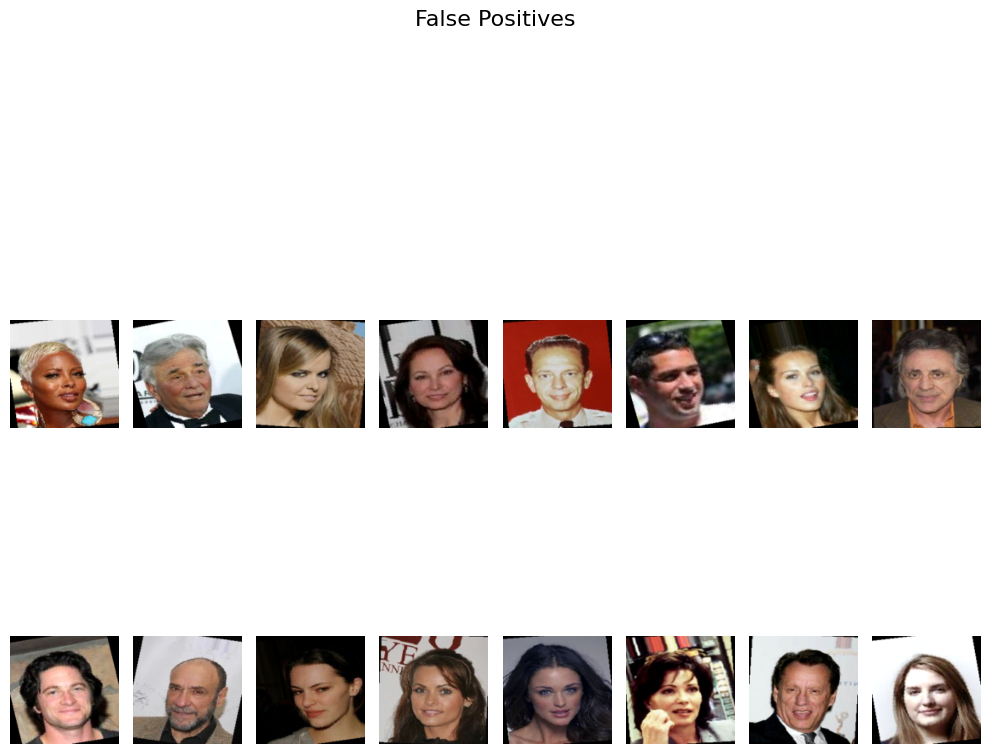

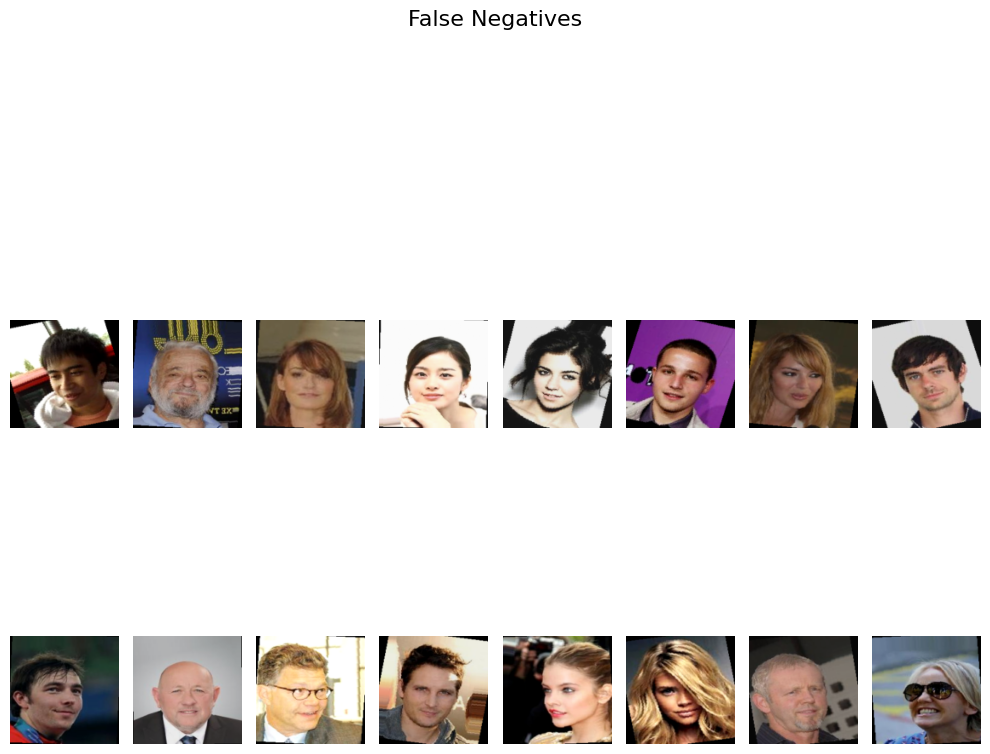

In [13]:
import matplotlib.pyplot as plt

# Create lists to store indices
false_positive_indices = []
false_negative_indices = []
images_store = []

# Analyze errors
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        predicted = torch.sigmoid(outputs) > 0.5

        # Convert to CPU for easier indexing
        labels = labels.cpu()
        predicted = predicted.cpu()

        for i in range(len(labels)):
            if predicted[i] == 1 and labels[i] == 0:  # False Positive
                false_positive_indices.append((batch_idx, i))
            elif predicted[i] == 0 and labels[i] == 1:  # False Negative
                false_negative_indices.append((batch_idx, i))

def visualize_errors(indices, dataset, title, num_images=16, cols=8):
    """
    Visualize error images (false positives or negatives) from the dataset.

    Args:
    - indices: List of (batch_idx, image_idx) tuples for errors.
    - dataset: Dataset object (e.g., test_dataset).
    - title: Title for the visualization.
    - num_images: Number of images to visualize.
    """

    rows = (num_images + cols - 1) // cols  # Calculate number of rows
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)

    # Flatten axes for easier indexing
    axes = axes.flatten()

    for idx, (batch_idx, image_idx) in enumerate(indices[:num_images]):
        # Get the image from the dataset
        image, _ = dataset[batch_idx * test_loader.batch_size + image_idx]

        # Convert tensor to a displayable format
        image = image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Unnormalize

        # Display image in the corresponding subplot
        axes[idx].imshow(image)
        axes[idx].axis("off")

    # Turn off any unused axes
    for ax in axes[len(indices[:num_images]):]:
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()

visualize_errors(false_positive_indices, test_dataset, "False Positives")
visualize_errors(false_negative_indices, test_dataset, "False Negatives")



False postive correlated with mouth openness. out of 5 celeb smiling, two are not smiling but their mouth are open.   And False negative returns 5 image where one person is not smiling but the rest are slightly smiling

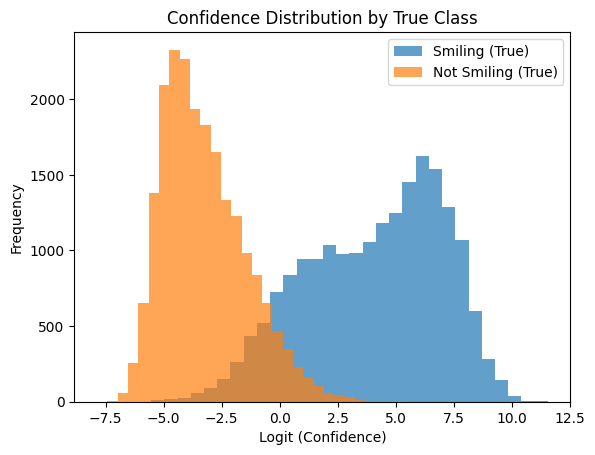

In [14]:
import numpy as np

# Collect logits and labels
logits = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        logits.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

logits = np.array(logits)
all_labels = np.array(all_labels)

# Plot confidence distribution
import matplotlib.pyplot as plt
plt.hist(logits[all_labels == 1], bins=30, alpha=0.7, label="Smiling (True)")
plt.hist(logits[all_labels == 0], bins=30, alpha=0.7, label="Not Smiling (True)")
plt.xlabel("Logit (Confidence)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Confidence Distribution by True Class")
plt.show()


In [15]:
result_table.sortby = "Confidence"
result_table.reversesort = True

In [16]:
result_table_csv = pd.DataFrame([
    [image_id, true_label, pred_label, confidence]
    for image_id, true_label, pred_label, confidence in zip(
        attributes.iloc[test_indices]["image_id"],
        y_true,
        y_pred,
        [torch.sigmoid(torch.tensor(logit)).item() for logit in logits]
    )
], columns=["Image ID", "True Label", "Predicted Label", "Confidence"])

result_table_csv.to_csv("classification_results.csv", index=False)


In [17]:
# Use a dictionary to track unique entries
unique_results = {}

for idx, (true_label, pred_label, logit) in enumerate(zip(y_true, y_pred, logits)):
    image_id = attributes.iloc[test_indices[idx]]["image_id"]
    confidence = torch.sigmoid(torch.tensor(logit)).item()

    # Store the result in the dictionary, keyed by image_id
    unique_results[image_id] = {
        "True Label": "Smiling" if true_label == 1 else "Not Smiling",
        "Predicted Label": "Smiling" if pred_label == 1 else "Not Smiling",
        "Confidence": f"{confidence:.2f}" + ("*" if true_label != pred_label else "")
    }

# Create a PrettyTable from the unique results
result_table = PrettyTable()
result_table.field_names = ["Image ID", "True Label", "Predicted Label", "Confidence"]

for image_id, values in unique_results.items():
    result_table.add_row([image_id, values["True Label"], values["Predicted Label"], values["Confidence"]])

# Display the table
print(result_table)


+------------+-------------+-----------------+------------+
|  Image ID  |  True Label | Predicted Label | Confidence |
+------------+-------------+-----------------+------------+
| 093242.jpg | Not Smiling |   Not Smiling   |    0.05    |
| 121414.jpg | Not Smiling |   Not Smiling   |    0.01    |
| 010625.jpg | Not Smiling |   Not Smiling   |    0.23    |
| 082524.jpg |   Smiling   |     Smiling     |    0.97    |
| 073193.jpg |   Smiling   |     Smiling     |    1.00    |
| 176200.jpg | Not Smiling |   Not Smiling   |    0.00    |
| 041602.jpg | Not Smiling |   Not Smiling   |    0.17    |
| 065466.jpg | Not Smiling |   Not Smiling   |    0.38    |
| 019028.jpg |   Smiling   |     Smiling     |    1.00    |
| 164498.jpg |   Smiling   |     Smiling     |    1.00    |
| 123185.jpg |   Smiling   |   Not Smiling   |   0.10*    |
| 155484.jpg | Not Smiling |   Not Smiling   |    0.03    |
| 000274.jpg |   Smiling   |     Smiling     |    1.00    |
| 117625.jpg | Not Smiling |   Not Smili